## Import

In [1]:
import numpy as np
#from scipy import stats
import matplotlib.pyplot as plt
import matplotlib

import torch 
from torch import distributions
from torch import nn
from torch.utils import data

## Model

### DoubleWell

In [2]:
class DoubleWell(object):

    params_default = {'a4' : 1.0,
                      'a2' : 6.0,
                      'a1' : 1.0,
                      'k' : 1.0,
                      'dim' : 2}

    def __init__(self, params=None):
        # set parameters
        if params is None:
            params = self.__class__.params_default
        self.params = params

        # useful variables
        self.dim = self.params['dim']

    def energy(self, x):
        dimer_energy =self.params['a4'] * x[:, 0] ** 4 - self.params['a2'] * x[:, 0] ** 2 + self.params['a1'] * x[:, 0]
        oscillator_energy = 0.0
        if self.dim == 2:
            oscillator_energy = (self.params['k'] / 2.0) * x[:, 1] ** 2
        if self.dim > 2:
            oscillator_energy = np.sum((self.params['k'] / 2.0) * x[:, 1:] ** 2, axis=1)
        return  dimer_energy + oscillator_energy

#    def energy_tf(self, x):
#        return self.energy(x)

    def plot_dimer_energy(self, axis=None, temperature=1.0):
        """ Plots the dimer energy to the standard figure """
        x_grid = np.linspace(-3, 3, num=200)
        if self.dim == 1:
            X = x_grid[:, None]
        else:
            X = np.hstack([x_grid[:, None], np.zeros((x_grid.size, self.dim - 1))])
        energies = self.energy(X) / temperature

#        import matplotlib.pyplot as plt
        if axis is None:
            axis = plt.gca()
        #plt.figure(figsize=(5, 4))
        axis.plot(x_grid, energies, linewidth=3, color='black')
        axis.set_xlabel('x / a.u.')
        axis.set_ylabel('Energy / kT')
        axis.set_ylim(energies.min() - 2.0, energies[int(energies.size / 2)] + 2.0)
#        plt.show()

        return x_grid, energies

### BG

In [3]:
class BG_RealNVP(nn.Module):
  def __init__(self, n_hidden=256, n_block=5, target=None, prior=None, masks=None):
    super(BG_RealNVP,self).__init__()

    if target==None:
      target=DoubleWell()
    self.target=target
    self.n_hidden=n_hidden
    self.n_block=n_block

    nets = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2), nn.Tanh())

    nett = lambda: nn.Sequential(nn.Linear(2, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, self.n_hidden), nn.ReLU(), nn.Linear(self.n_hidden, 2))

    if prior==None:
      self.prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    if masks==None:
      self.masks = nn.Parameter(torch.from_numpy(np.array([[0, 1], [1, 0]] * self.n_block).astype(np.float32)), requires_grad=False)

    self.nett = torch.nn.ModuleList([nett() for _ in range(len(self.masks))]) # translation
    self.nets = torch.nn.ModuleList([nets() for _ in range(len(self.masks))]) # scaling 


  def target_energy(self,x):
    return self.target.energy(x)

  def prior_energy(self, z):
    return 0.5*torch.linalg.norm(z,dim=1)**2

  def forward_flow(self,z):
    log_R_zx, x = z.new_zeros(z.shape[0]), z

    for i in range(len(self.masks)):
      x1= x*self.masks[i]

      s=self.nets[i](x1)*(1-self.masks[i])
      t=self.nett[i](x1)*(1-self.masks[i])

      x=x1+(1-self.masks[i])* (x*torch.exp(s)+t)
      log_R_zx+=torch.sum(s,-1)

    return x, log_R_zx

  def backward_flow(self,x):

    log_R_xz, z = x.new_zeros(x.shape[0]), x

    for i in reversed(range(len(self.masks))):
      z1= z*self.masks[i]

      s=self.nets[i](z1)*(1-self.masks[i])
      t=self.nett[i](z1)*(1-self.masks[i])

      z=z1+(1-self.masks[i])*(z-t)*torch.exp(-s)
      log_R_xz-=torch.sum(s,-1)

    return z, log_R_xz

  def sample(self, batchSize):
      z = self.prior.sample((batchSize,))
      x, log_R_zx = self.forward_flow(z)
      d_energy=self.prior_energy(z)-self.target_energy(x)+log_R_zx
      reweighting = torch.exp(d_energy)
      return z.detach().numpy(), x.detach().numpy(), reweighting.detach().numpy()

  def loss(self, batch, w_ml = 1.0, w_kl = 0.0):
      return w_ml*self.loss_ml(batch) + w_kl*self.loss_kl(batch)  

  def loss_ml(self, batch_x):
      z, log_R_xz = self.backward_flow(batch_x)
      energy=0.5*torch.linalg.norm(z,dim=1)**2
      return torch.mean(energy-log_R_xz)

  def loss_kl(self, batch_z):
      x, log_R_zx = self.forward_flow(batch_z)
      energy=self.target_energy(x)
      e_high=1e10
      for i in range(len(energy)):
        if abs(energy[i]) == float('inf'):
                print("energy overflow detected")
        elif energy[i] > e_high:
                energy[i] = e_high + torch.log(energy[i] - e_high + 1.0)
      return torch.mean(energy - log_R_zx)  

  def train_ML(self, x):
    iter=100
    lr=1e-3
    batch_size=1024

    training_data=x
#    np.random.shuffle(training_data)
    optimizer = torch.optim.Adam(self.parameters(), lr=lr) 
#    training_data = training_data.astype('float32')
    trainloader = data.DataLoader(dataset=training_data, batch_size=batch_size)

    losses = []
    t = 0 # iteration count
    while t < iter:
      for batch in trainloader:  

        # Custom ML loss function
        loss = self.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 

        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        t=t+1
        
    return losses

### Explore

In [4]:
class Configuration(object):
  def __init__(self, bg, X0, capacity, batch_size=1024):
    self.bg=bg
    self.lr=1e-3
    self.batch_size=batch_size

    self.I = np.arange(capacity)
    I_X0=np.arange(X0.shape[0])
    I_select=np.random.choice(I_X0, size=capacity, replace=True)
    self.X=X0[I_select]

    self.loss_train = []
    self.acceptance_rate = []
    self.stepsize = []

  def configure(self, epochs, stepsize=0.1):
    if stepsize is None:  # initialize stepsize when called for the first time
        if len(self.stepsize) == 0:
            self.stepsize.append(0.1)
    else:
        self.stepsize = [stepsize]

    for e in range(epochs):
      
        #sample batch
        I_select=np.random.choice(self.I,size=self.batch_size, replace=True)
        x_batch=torch.from_numpy(self.X[I_select])

        #train 
        loss=self.bg.train_ML(x_batch)
        print('iter %s:' % e, 'loss = %.3f' % loss[-1])       

        
        z_batch, Jxz_batch = self.bg.backward_flow(x_batch)
        
        

        E0 = self.bg.target_energy(x_batch) + Jxz_batch
#        E0 = self.bg.target_energy(x_batch)


        #methopolis
        z_batch_new = z_batch + self.stepsize[-1] * torch.randn(z_batch.shape[0], z_batch.shape[1])

        x_batch_new, Jzx_batch_new = self.bg.forward_flow(z_batch_new)
        E1 = self.bg.target_energy(x_batch) - Jzx_batch_new
#        E1 = self.bg.target_energy(x_batch)
    
    
        #accept and replace
        rand = -torch.log(torch.rand(self.batch_size))
        Iacc = rand >= E1-E0

        x_acc = x_batch_new[Iacc]
        self.X[I_select[Iacc]] = x_acc.detach().numpy()

        pacc = float(np.count_nonzero(Iacc)) / float(self.batch_size)
        self.acceptance_rate.append(pacc)



## Data

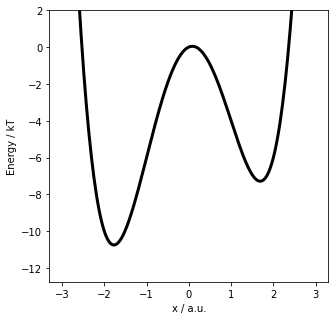

In [5]:
params = DoubleWell.params_default.copy()
params['dim'] = 2
double_well = DoubleWell(params=params)
plt.figure(figsize=(5,5))
double_well.plot_dimer_energy();

## Train

In [6]:
BG=BG_RealNVP()

In [7]:
X0=np.array([[-1.8,0.]]).astype('float32')

In [8]:
Explore_DoubleWell=Configuration(BG,X0,capacity=10000)

In [9]:
Explore_DoubleWell.stepsize

[]

In [10]:
Explore_DoubleWell.configure(epochs=1000)

iter 0: loss = 2.888
iter 1: loss = -2.619
iter 2: loss = -3.180
iter 3: loss = -1.069
iter 4: loss = -6.194
iter 5: loss = -4.338
iter 6: loss = -3.829
iter 7: loss = -6.133
iter 8: loss = -5.514
iter 9: loss = -6.051
iter 10: loss = -3.552
iter 11: loss = -5.706
iter 12: loss = -6.125
iter 13: loss = -6.911
iter 14: loss = -7.217
iter 15: loss = -7.341
iter 16: loss = -6.777
iter 17: loss = -6.684
iter 18: loss = -6.292
iter 19: loss = -6.448
iter 20: loss = -5.597
iter 21: loss = -6.114
iter 22: loss = -6.409
iter 23: loss = -6.828
iter 24: loss = -7.488
iter 25: loss = -6.954
iter 26: loss = -7.154
iter 27: loss = -7.336
iter 28: loss = -7.238
iter 29: loss = -7.318
iter 30: loss = -7.639
iter 31: loss = -7.347
iter 32: loss = -7.571
iter 33: loss = -7.328
iter 34: loss = -7.402
iter 35: loss = -7.623
iter 36: loss = -4.553
iter 37: loss = -7.226
iter 38: loss = -6.982
iter 39: loss = -6.974
iter 40: loss = -5.672
iter 41: loss = -5.982
iter 42: loss = -6.102
iter 43: loss = -6.403

iter 347: loss = 0.077
iter 348: loss = 0.408
iter 349: loss = 0.217
iter 350: loss = 0.021
iter 351: loss = -0.153
iter 352: loss = -0.008
iter 353: loss = -0.039
iter 354: loss = 0.814
iter 355: loss = 1.051
iter 356: loss = 1.202
iter 357: loss = -0.030
iter 358: loss = 0.484
iter 359: loss = 0.090
iter 360: loss = 0.309
iter 361: loss = -0.186
iter 362: loss = 0.005
iter 363: loss = 0.061
iter 364: loss = -0.537
iter 365: loss = -0.318
iter 366: loss = 0.451
iter 367: loss = 0.156
iter 368: loss = 0.306
iter 369: loss = 1.210
iter 370: loss = 1.212
iter 371: loss = 0.213
iter 372: loss = 0.757
iter 373: loss = -0.069
iter 374: loss = -0.131
iter 375: loss = -0.297
iter 376: loss = 0.076
iter 377: loss = 0.445
iter 378: loss = 0.554
iter 379: loss = 0.182
iter 380: loss = 0.353
iter 381: loss = 0.424
iter 382: loss = 0.494
iter 383: loss = 0.212
iter 384: loss = 0.091
iter 385: loss = 0.289
iter 386: loss = 0.452
iter 387: loss = 0.528
iter 388: loss = 0.392
iter 389: loss = 0.459
i

iter 703: loss = 3.655
iter 704: loss = 3.777
iter 705: loss = 3.674
iter 706: loss = 3.895
iter 707: loss = 3.781
iter 708: loss = 3.648
iter 709: loss = 3.914
iter 710: loss = 4.089
iter 711: loss = 4.673
iter 712: loss = 4.454
iter 713: loss = 4.480
iter 714: loss = 4.386
iter 715: loss = 4.171
iter 716: loss = 3.865
iter 717: loss = 4.194
iter 718: loss = 4.049
iter 719: loss = 4.466
iter 720: loss = 4.384
iter 721: loss = 3.904
iter 722: loss = 4.056
iter 723: loss = 3.709
iter 724: loss = 3.894
iter 725: loss = 4.334
iter 726: loss = 3.995
iter 727: loss = 4.550
iter 728: loss = 4.341
iter 729: loss = 4.434
iter 730: loss = 5.103
iter 731: loss = 4.189
iter 732: loss = 4.208
iter 733: loss = 4.144
iter 734: loss = 4.512
iter 735: loss = 4.208
iter 736: loss = 4.760
iter 737: loss = 4.968
iter 738: loss = 4.253
iter 739: loss = 4.125
iter 740: loss = 4.275
iter 741: loss = 4.176
iter 742: loss = 4.225
iter 743: loss = 4.209
iter 744: loss = 4.397
iter 745: loss = 4.921
iter 746: l

In [11]:
x=BG.sample(10000)[1]

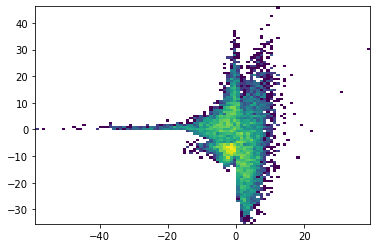

In [12]:
ax=plt.gca()
ax.hist2d(x[:,0],x[:,1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [13]:
Explore_DoubleWell.acceptance_rate

[0.6884765625,
 0.9345703125,
 0.951171875,
 0.9345703125,
 0.9482421875,
 0.9345703125,
 0.99609375,
 0.95703125,
 0.955078125,
 0.953125,
 0.912109375,
 0.951171875,
 0.9736328125,
 0.970703125,
 0.9677734375,
 0.97265625,
 0.892578125,
 0.96484375,
 0.96875,
 0.9755859375,
 0.86328125,
 0.9365234375,
 0.935546875,
 0.939453125,
 0.9501953125,
 0.955078125,
 0.955078125,
 0.935546875,
 0.9423828125,
 0.9365234375,
 0.9453125,
 0.939453125,
 0.9345703125,
 0.943359375,
 0.935546875,
 0.939453125,
 0.72265625,
 0.943359375,
 0.9384765625,
 0.9375,
 0.974609375,
 0.978515625,
 0.9765625,
 0.9697265625,
 0.9521484375,
 0.9619140625,
 0.9375,
 0.9248046875,
 0.93359375,
 0.9228515625,
 0.93359375,
 0.935546875,
 0.93359375,
 0.9287109375,
 0.9287109375,
 0.9189453125,
 0.9365234375,
 0.9189453125,
 0.9033203125,
 0.9208984375,
 0.916015625,
 0.91015625,
 0.931640625,
 0.9248046875,
 0.9072265625,
 0.921875,
 0.921875,
 0.916015625,
 0.8955078125,
 0.890625,
 0.9228515625,
 0.921875,
 0.92